# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Is the pipeline functional?
  * Check of output at each stage of pipeline
* **Note:** using diffusion method from Meselson etla., 1957

# Setting variables

In [12]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/Meselson_diff/validation/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
#figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

bandwidth = 0.8
DBL_scaling = 0.5
subsample_dist = 'lognormal'
subsample_mean = 9.432
subsample_scale = 0.5
subsample_min = 10000
subsample_max = 30000

# Init

In [13]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [14]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [15]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome1147/Meselson_diff/validation


In [16]:
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_range_BD)
print 'Max BD: {}'.format(max_range_BD)

Min BD: 1.67323
Max BD: 1.7744


# Creating a community file

* 2 communities
  * control vs treatment

In [17]:
!SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

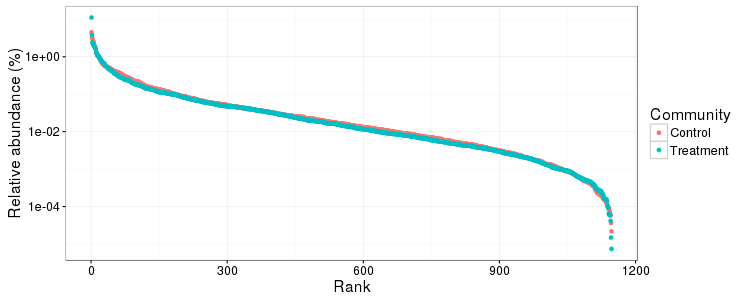

In [18]:
%%R -w 750 -h 300


tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)
tbl$library = ifelse(tbl$library == 1, 'Control', 'Treatment')

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    scale_color_discrete('Community') +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating gradient fractions

In [19]:
!SIPSim gradient_fractions \
    --BD_min $min_range_BD \
    --BD_max $max_range_BD \
    comm.txt \
    > fracs.txt    

## Plotting fractions

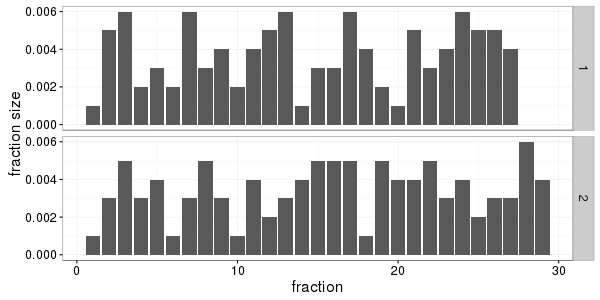

In [20]:
%%R -w 600 -h 300

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

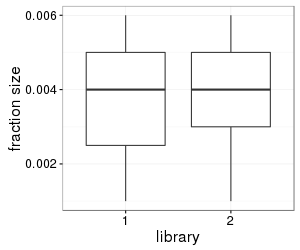

In [21]:
%%R -w 300 -h 250
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating fragments

In [22]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [26]:
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Number of amplicons per taxon

In [27]:
!grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 338|    o       
 320|    o       
 303|    o       
 285|    o       
 268|    o       
 250|    o       
 232|   oo       
 215|   oo       
 197|   oo       
 180|   oo       
 162|   oo o     
 144|   oo o     
 127|  ooo o     
 109|  ooo o     
  92|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1147     |
|    min value: 0.000000     |
|      mean : 3.823888       |
|    max value: 15.000000    |
------------------------------


In [28]:
!printf "Number of taxa with >=1 amplicon: "
!grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1102


# Converting fragments to kde object

In [29]:
!SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [30]:
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [31]:
%%R 
# loading
df = read.delim('ampFrags_kde_info.txt', sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

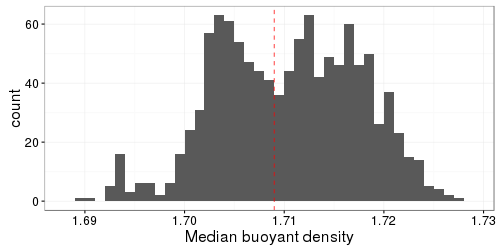

In [32]:
%%R -w 500 -h 250
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Adding diffusion

In [ ]:
!SIPSim diffusion \
    --bw $bandwidth \
    --np 24 \
    -m Meselson \
    ampFrags_kde.pkl \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'contamination'

* DBL = diffusive boundary layer

In [48]:
!SIPSim DBL \
    --comm comm.txt \
    --commx $DBL_scaling \
    --np 24 \
    ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_DBL.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!tail -n 5 ampFrags_kde_dif_DBL.log

Processing: Campylobacter_ureolyticus_RIGS_9880
Processing: Dyadobacter_fermentans_DSM_18053
Processing: Ruminococcus_albus_7_DSM_20455
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Mycobacterium_africanum_GM041182


## Comparing DBL+diffusion to diffusion

In [50]:
# none
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [51]:
%%R 

inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'raw'

inFile = 'ampFrags_kde_dif_info.txt'
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'

inFile = 'ampFrags_kde_dif_DBL_info.txt'
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID        min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1   1.706491     1.707267
2      1 Tropheryma_whipplei_str_Twist      2 314.000000  4226.000000
3      1   Caldisericum_exile_AZM16c01    NaN        NaN          NaN
  percentile_25        mean      median percentile_75 percentile_95
1      1.708207    1.709664    1.709788      1.710664      1.712583
2   6103.750000 7048.006200 7328.000000   8184.250000   9079.050000
3           NaN         NaN         NaN           NaN           NaN
           max        stdev stage
1     1.718247 1.632616e-03   raw
2 10542.000000 1.520569e+03   raw
3          NaN          NaN   raw


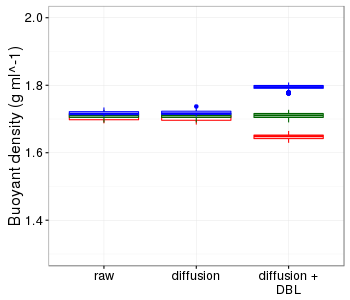

In [52]:
%%R -w 350 -h 300

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Making an incorp config file

* 10% of taxa with 100% atom excess 13C

In [54]:
!SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config
    
# checking output
!head PT10_PI100.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            


# Adding isotope incorporation to BD distribution

In [55]:
!SIPSim isotope_incorp \
    --comm comm.txt \
    --np 24 \
    --shift ampFrags_BD-shift.txt \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    > ampFrags_kde_dif_DBL_incorp.pkl \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking log
!tail -n 5 ampFrags_kde_dif_DBL_incorp.log

Processing: Neorhizobium_galegae_bv_officinalis_bv_officinalis_str_HAMBI_1141
Processing: Campylobacter_ureolyticus_RIGS_9880
Processing: Dyadobacter_fermentans_DSM_18053
Processing: Xanthomonas_axonopodis_Xac29-1
File written: ampFrags_BD-shift.txt


# Plotting stats on BD shift from isotope incorporation

In [56]:
%%R
inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

    library incorporator n_incorps n_incorps/sum(n_incorps)
1 treatment        FALSE       992               0.90018149
2 treatment         TRUE       110               0.09981851


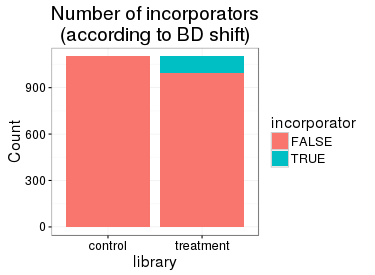

In [57]:
%%R -h 275 -w 375

inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

df.s = df %>% 
    mutate(incorporator = ifelse(min > 0.001, TRUE, FALSE),
           incorporator = ifelse(is.na(incorporator), 'NA', incorporator),
           library = ifelse(library == '1', 'control', 'treatment')) %>%
    group_by(library, incorporator) %>%
    summarize(n_incorps = n())

# summary of number of incorporators
df.s %>%
    filter(library == 'treatment') %>%
    mutate(n_incorps / sum(n_incorps)) %>% 
    as.data.frame %>% print

# plotting
ggplot(df.s, aes(library, n_incorps, fill=incorporator)) +
    geom_bar(stat='identity') +
    labs(y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Simulating an OTU table

In [58]:
!SIPSim OTU_table \
    --abs 1e9 \
    --np 20 \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!tail -n 5 OTU_n2_abs1e9.log 

   taxon abs-abundance:  11882638
  Processing taxon: "Candidatus_Symbiobacter_mobilis_CR"
   taxon abs-abundance:  11701149
  Processing taxon: "Sphingomonas_wittichii_RW1"
   taxon abs-abundance:  10503711


## Plotting taxon abundances

In [59]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

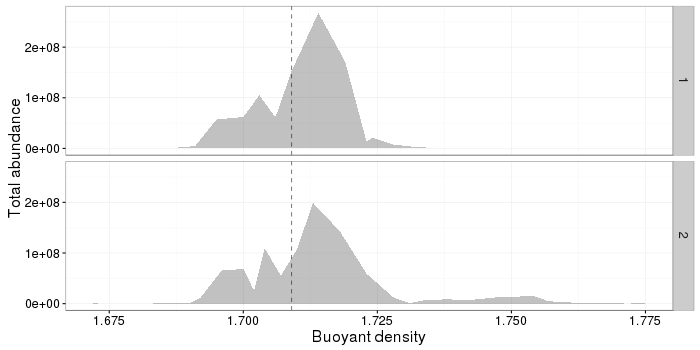

In [60]:
%%R -w 700 -h 350
# plotting absolute abundances

# loading file
df = read.delim('OTU_n2_abs1e9.txt', sep='\t') 

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

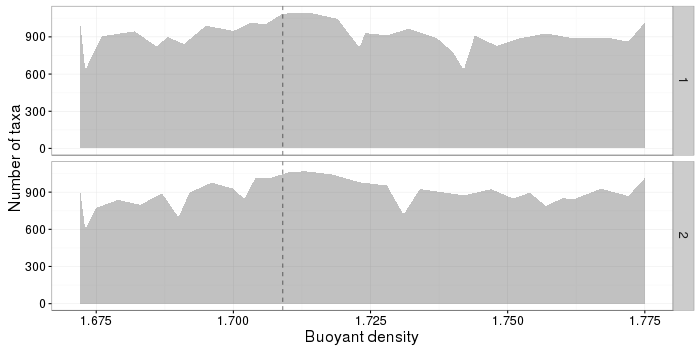

In [61]:
%%R -w 700 -h 350
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

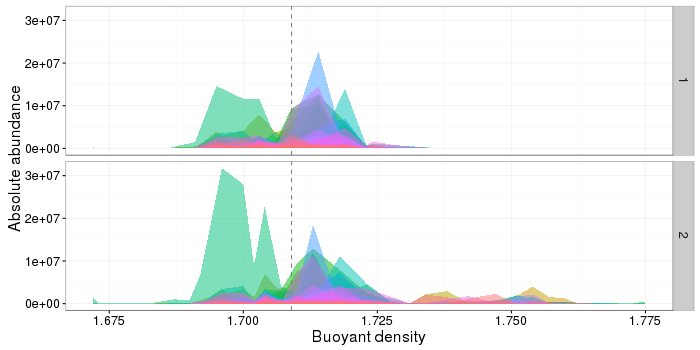

In [62]:
%%R -w 700 -h 350
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

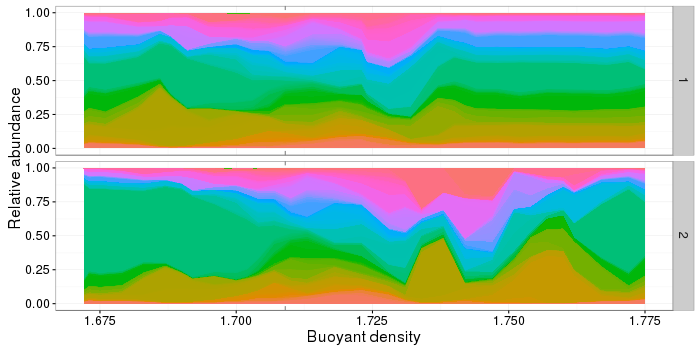

In [63]:
%%R -w 700 -h 350
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Simulating PCR bias

In [64]:
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

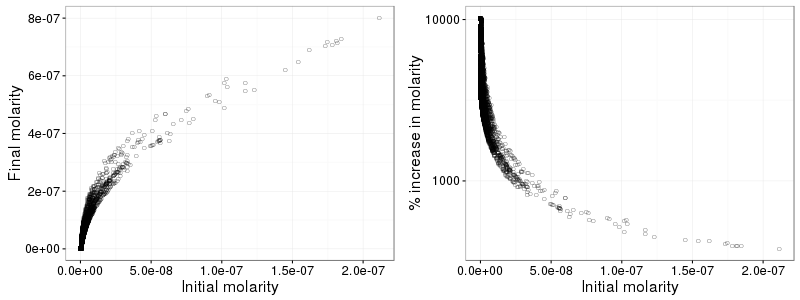

In [65]:
%%R -w 800 -h 300
# loading file
F = 'OTU_n2_abs1e9_PCR.txt'
df.SIM = read.delim(F, sep='\t') %>%
    mutate(molarity_increase = final_molarity / init_molarity * 100)

p1 = ggplot(df.SIM, aes(init_molarity, final_molarity)) +
    geom_point(shape='O', alpha=0.5) +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(init_molarity, molarity_increase)) +
    geom_point(shape='O', alpha=0.5) +
    scale_y_log10() +
    labs(x='Initial molarity', y='% increase in molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=2)

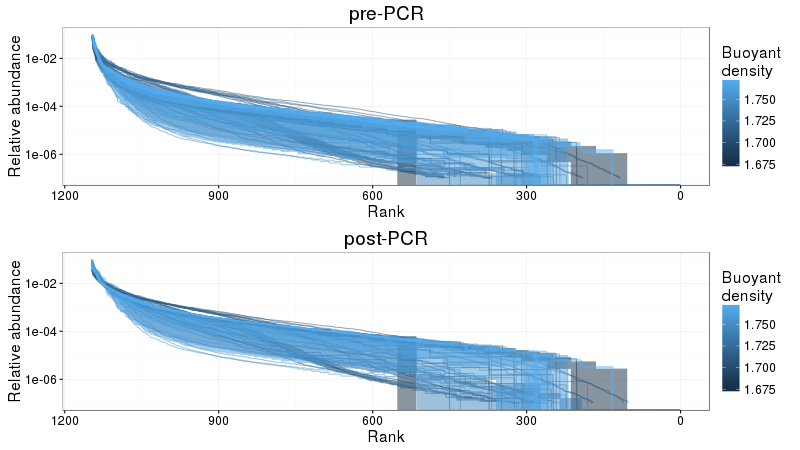

In [66]:
%%R -w 800 -h 450
# plotting rank abundances

df.SIM = df.SIM %>%
    group_by(library, fraction) %>%
    mutate(rel_init_molarity = init_molarity / sum(init_molarity),
           rel_final_molarity = final_molarity / sum(final_molarity),
           init_molarity_rank = row_number(rel_init_molarity),
           final_molarity_rank = row_number(rel_final_molarity)) %>%
    ungroup() 
    

p1 = ggplot(df.SIM, aes(init_molarity_rank, rel_init_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='pre-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(final_molarity_rank, rel_final_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='post-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


grid.arrange(p1, p2, ncol=1)

#### Notes

* The PCR raises the relative abundances most for low-abundance taxa
* Results in a more even rank-abundance distribution

In [67]:
# PCR w/out --debug
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_PCR.txt

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [68]:
!SIPSim OTU_subsample \
    --dist $subsample_dist \
    --dist_params mean:$subsample_mean,sigma:$subsample_scale \
    --min_size $subsample_min \
    --max_size $subsample_max \
    OTU_n2_abs1e9_PCR.txt \
    > OTU_n2_abs1e9_PCR_subNorm.txt

### Plotting seq count distribution

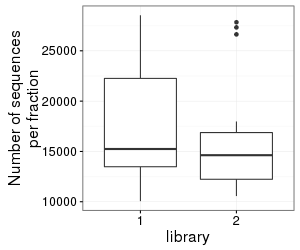

In [69]:
%%R -w 300 -h 250

df = read.csv('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    labs(y='Number of sequences\nper fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions (paper figure)

In [70]:
%%R 

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

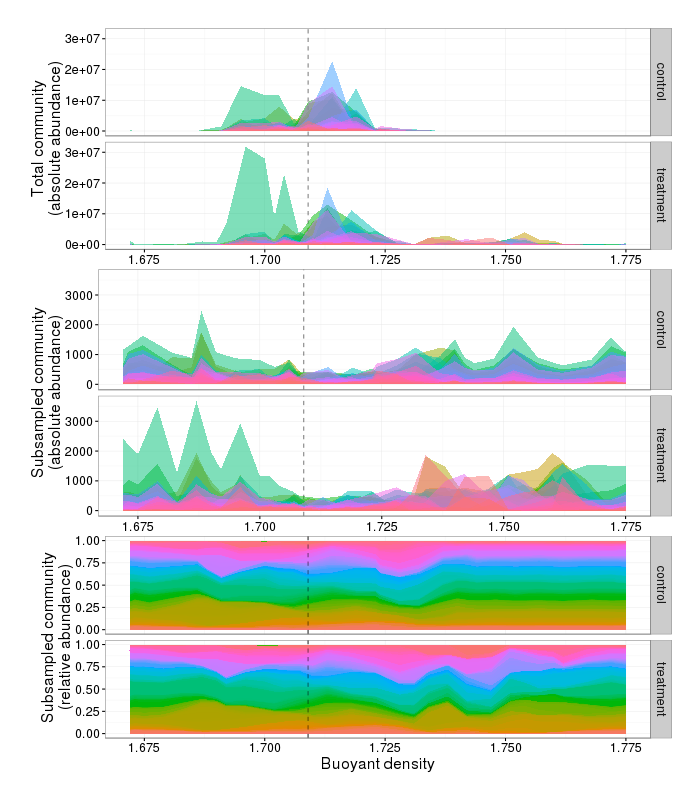

In [71]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

# Making a wide OTU table

In [73]:
!SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [87]:
!SIPSim OTU_sampleData \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_meta.txt

# Community analysis

## Phyloseq

In [75]:
# making phyloseq object from OTU table
!SIPSimR phyloseq_make \
    OTU_n2_abs1e9_PCR_subNorm_w.txt \
    -s OTU_n2_abs1e9_PCR_subNorm_meta.txt \
    > OTU_n2_abs1e9_PCR_subNorm.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf    

## filtering phyloseq object to just taxa/samples of interest (eg., BD-min/max)
!SIPSimR phyloseq_edit \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_PCR_subNorm_filt.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf
    
# making png figures
!convert OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png
!convert OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.1177682 
Run 1 stress 0.1732092 
Run 2 stress 0.1808809 
Run 3 stress 0.1787108 
Run 4 stress 0.1703011 
Run 5 stress 0.1794271 
Run 6 stress 0.1768901 
Run 7 stress 0.1792071 
Run 8 stress 0.1177708 
... procrustes: rmse 0.0004672379  max resid 0.003130078 
*** Solution reached
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: repla

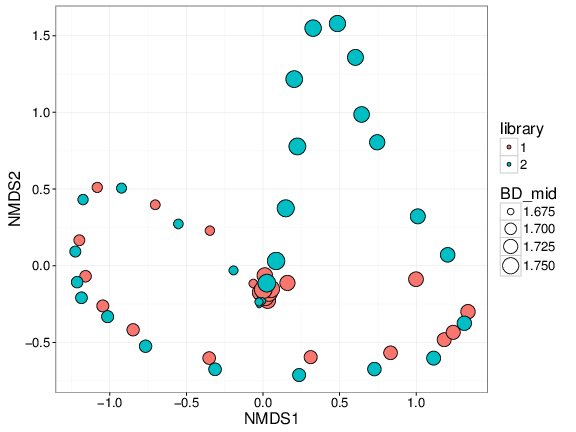

In [76]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png') 

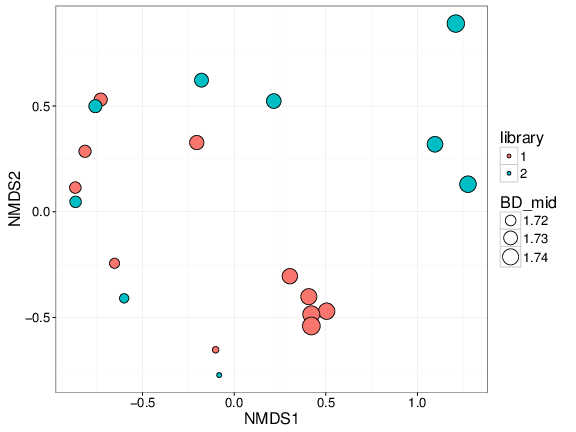

In [77]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png')

## DESeq2

In [78]:
## DESeq2
!SIPSimR phyloseq_DESeq2 \
    --log2 0.25 \
    --hypo greater \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_DESeq2
    
## Confusion matrix
!SIPSimR DESeq2_confuseMtx \
    --padj 0.1 \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_DESeq2

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 90 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx
File written: DESeq2-cMtx_data.txt
File written: DESeq2-cMtx_table.txt
File written: DESeq2-cMtx_overall.txt
File written: DESeq2-cMtx_byClass.txt


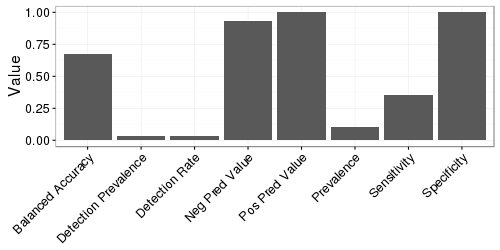

In [79]:
%%R -w 500 -h 250

byClass = read.delim('DESeq2-cMtx_byClass.txt', sep='\t') %>%
    filter(library == 2) 

ggplot(byClass, aes(variables, values)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

## Plotting results of DESeq2

In [80]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [81]:
%%R 

df = read.delim('DESeq2-cMtx_data.txt', sep='\t')

df = df %>%
    filter(! is.na(log2FoldChange), library == 2) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  library                                taxon min q25 mean median q75 max
1       2       Acaryochloris_marina_MBIC11017   0   0    0      0   0   0
2       2 Acetobacter_pasteurianus_IFO_3283-03   0   0    0      0   0   0
3       2       Acetobacterium_woodii_DSM_1030   0   0    0      0   0   0
   baseMean log2FoldChange    lfcSE stat    pvalue padj         p padj.BH
1 0.5326438      -1.508973 1.425381    0 0.8914054    1 0.8914054       1
2 0.3642897      -3.485138 1.807577    0 0.9806036    1 0.9806036       1
3 1.7348511      -2.250853 1.219069    0 0.9798882    1 0.9798882       1
  incorp.known incorp.pred           cls
1        FALSE       FALSE True negative
2        FALSE       FALSE True negative
3        FALSE       FALSE True negative


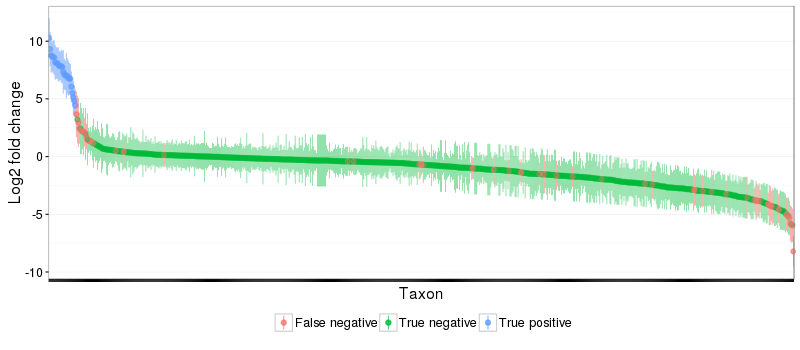

In [82]:
%%R -w 800 -h 350

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, 
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.4, alpha=0.5) +
    geom_pointrange(data=df.TP, size=0.4, alpha=0.3) +
    geom_pointrange(data=df.FP, size=0.4, alpha=0.3) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75
* Lines indicate standard errors.

# sensitivity ~ pre-frac relative_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [84]:
%%R
df.ds = read.delim('DESeq2-cMtx_data.txt', sep='\t') 
df.comm = read.delim('comm.txt', sep='\t')

df.j = inner_join(df.ds, df.comm, c('taxon' = 'taxon_name',
                                    'library' = 'library'))

df.ds = df.comm = NULL
df.j %>% head(n=3)

  library                                taxon min q25 mean median q75 max
1       2       Acaryochloris_marina_MBIC11017   0   0    0      0   0   0
2       2 Acetobacter_pasteurianus_IFO_3283-03   0   0    0      0   0   0
3       2       Acetobacterium_woodii_DSM_1030   0   0    0      0   0   0
   baseMean log2FoldChange    lfcSE stat    pvalue padj         p padj.BH
1 0.5326438      -1.508973 1.425381    0 0.8914054    1 0.8914054       1
2 0.3642897      -3.485138 1.807577    0 0.9806036    1 0.9806036       1
3 1.7348511      -2.250853 1.219069    0 0.9798882    1 0.9798882       1
  incorp.known incorp.pred rel_abund_perc rank
1        FALSE       FALSE     0.04773410  301
2        FALSE       FALSE     0.01863349  505
3        FALSE       FALSE     0.08959504  196


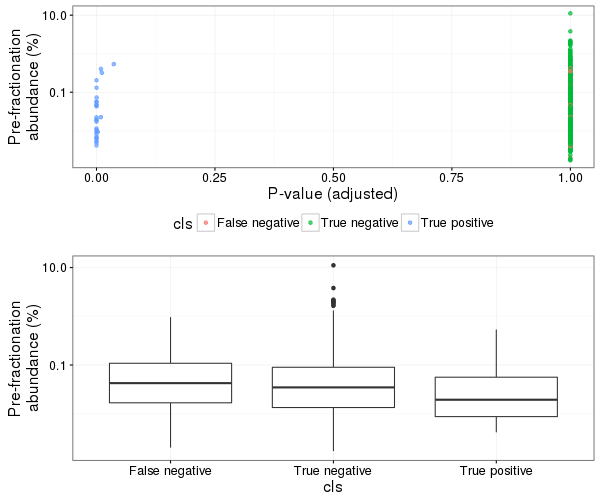

In [85]:
%%R -h 500 -w 600

df.j.f = df.j %>%
    filter(! is.na(log2FoldChange),
           library == 2) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) 

y.lab = 'Pre-fractionation\nabundance (%)'
p1 = ggplot(df.j.f, aes(padj, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='P-value (adjusted)', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )

p2 = ggplot(df.j.f, aes(cls, rel_abund_perc)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=1)

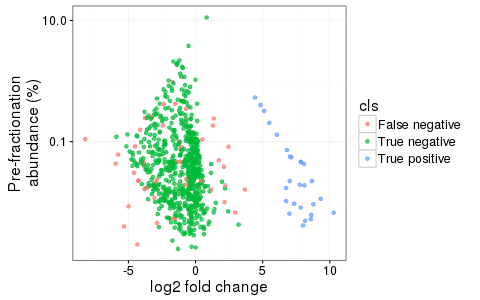

In [86]:
%%R -h 300
# plotting
ggplot(df.j.f, aes(log2FoldChange, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='log2 fold change', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


***